In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor

## Settings and helper functions

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(rc={'figure.figsize':(20,10)})

In [3]:
def print_metrics(y_true, y_pred):
    '''
    Prints regression metrics
    '''
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print("---> MAE: {}".format(mae))
    print("---> MSE: {}".format(mse))
    print("---> RMSE: {}".format(np.sqrt(mse)))

## Loading data and EDA

In [4]:
data = fetch_california_housing()

In [5]:
X, y = data.data, data.target
X = pd.DataFrame(X, columns=data.feature_names)
y = pd.DataFrame(y, columns=data.target_names)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [7]:
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


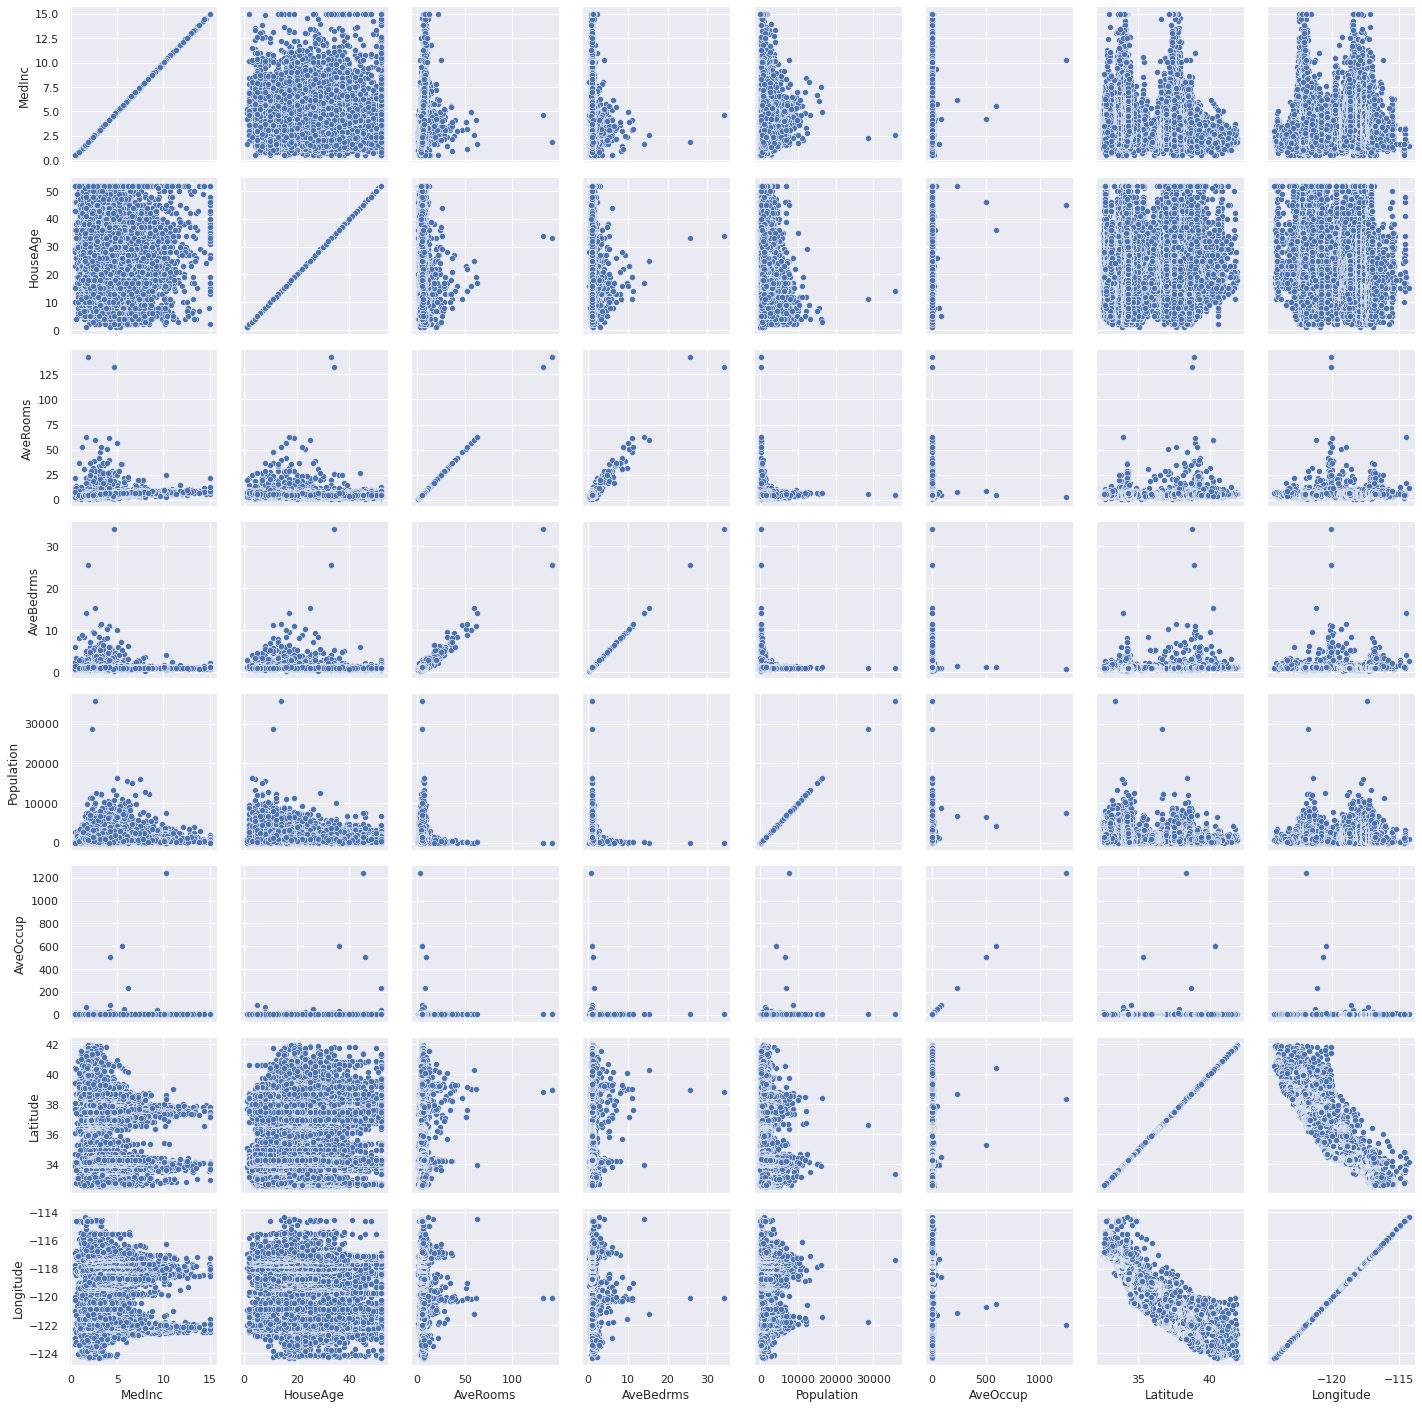

In [8]:
g = sns.PairGrid(X)
g.map(sns.scatterplot)

<AxesSubplot:xlabel='HouseAge', ylabel='MedInc'>

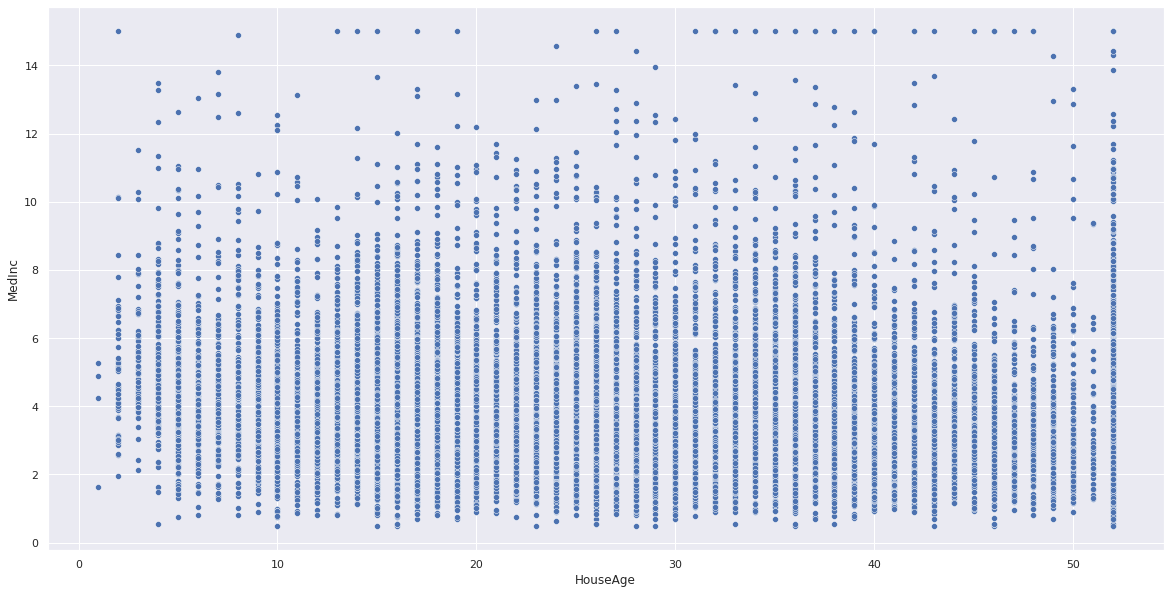

In [9]:
sns.scatterplot(x=X.HouseAge, y=X.MedInc)

<AxesSubplot:xlabel='MedInc', ylabel='Population'>

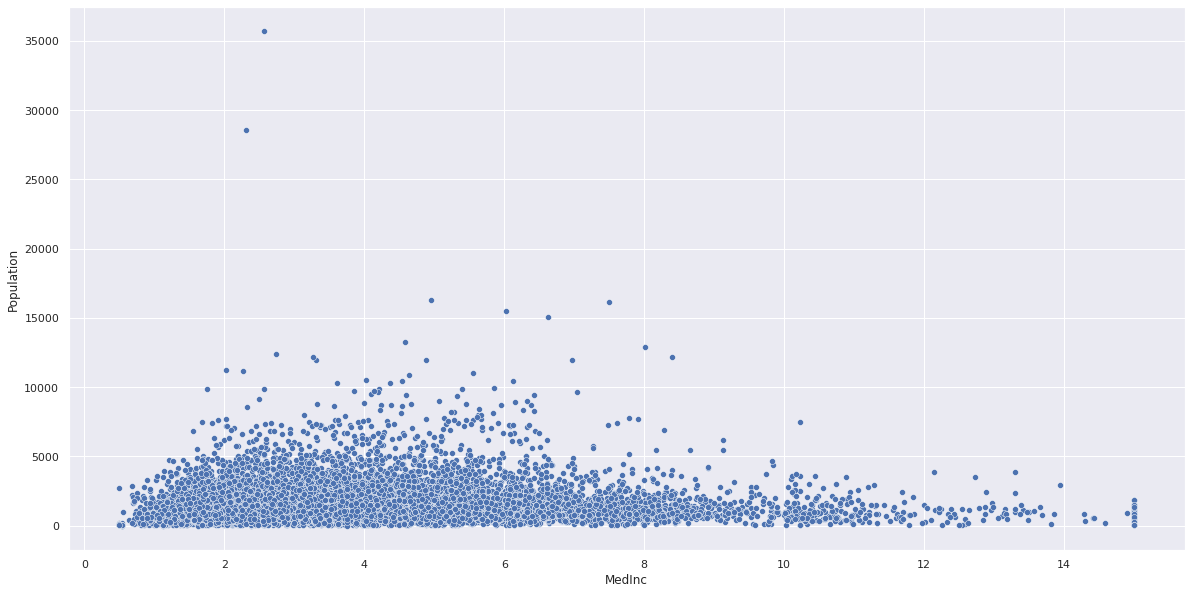

In [10]:
sns.scatterplot(x=X.MedInc, y=X.Population)

<AxesSubplot:xlabel='AveRooms', ylabel='AveBedrms'>

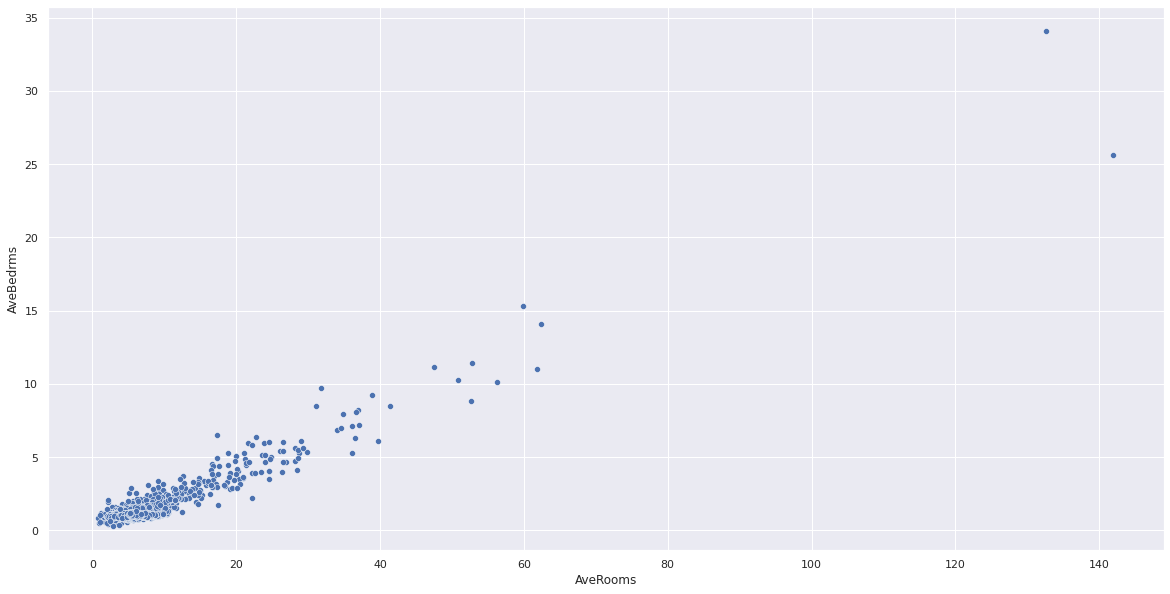

In [11]:
sns.scatterplot(x=X.AveRooms, y=X.AveBedrms)

<AxesSubplot:xlabel='AveRooms', ylabel='Population'>

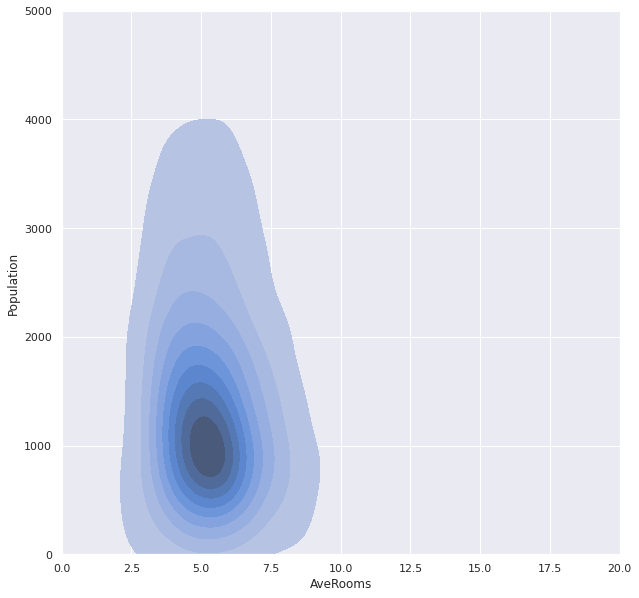

In [12]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=X.AveRooms, y=X.Population, clip=[(0,20), (0,5000)], shade=True)

<AxesSubplot:xlabel='HouseAge', ylabel='Population'>

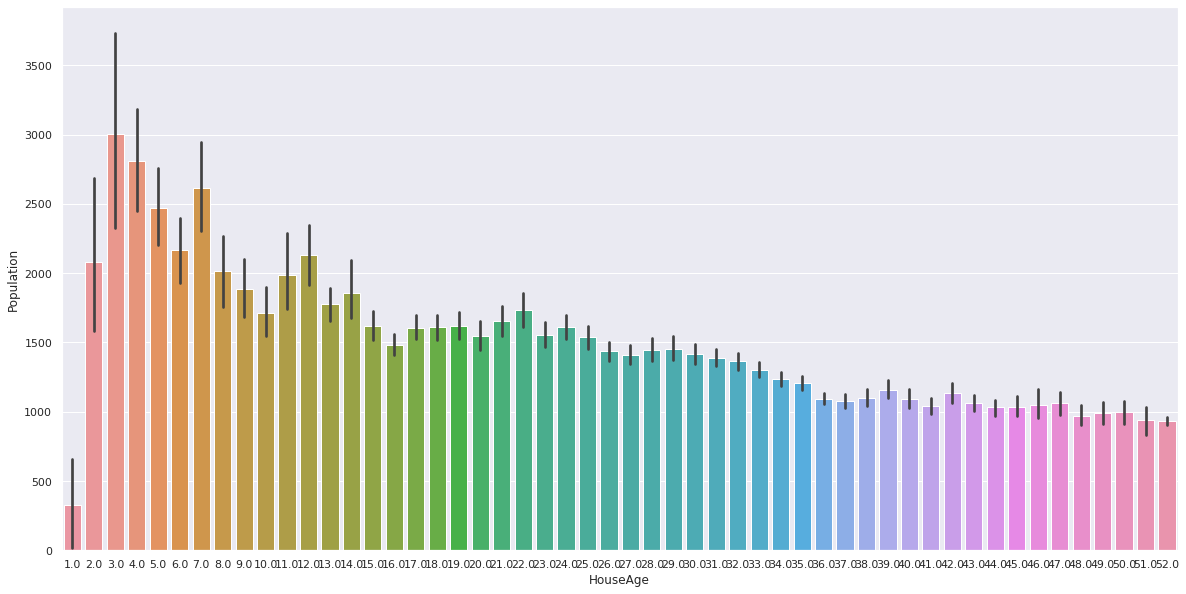

In [13]:
plt.figure(figsize=(20,10))
sns.barplot(x=X.HouseAge, y=X.Population)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

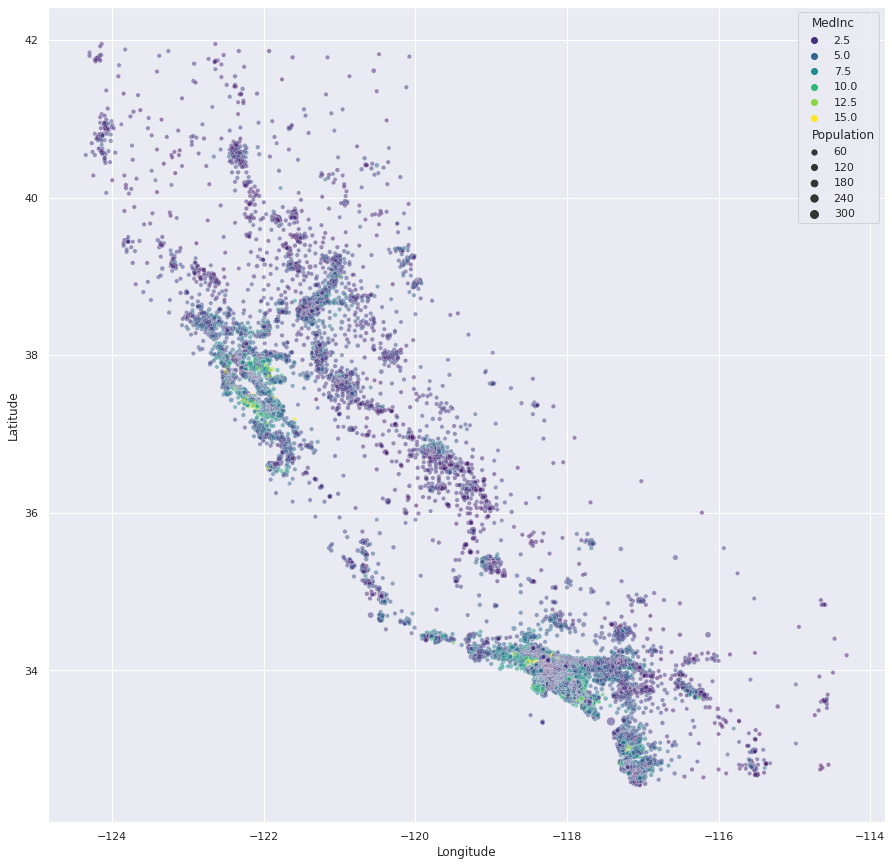

In [14]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=X.Longitude, y=X.Latitude, size=X.Population/100, hue=X.MedInc, palette='viridis', alpha=.5)

<AxesSubplot:>

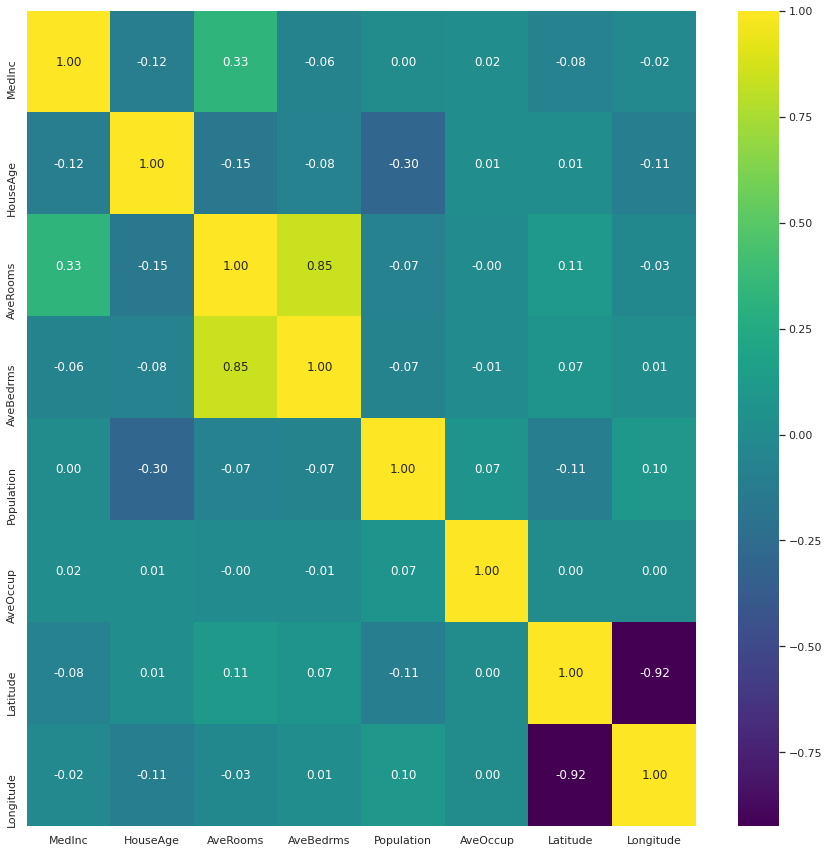

In [15]:
corr = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='viridis', annot=True, fmt='.2f')

Text(0.5, 1.0, 'Population')

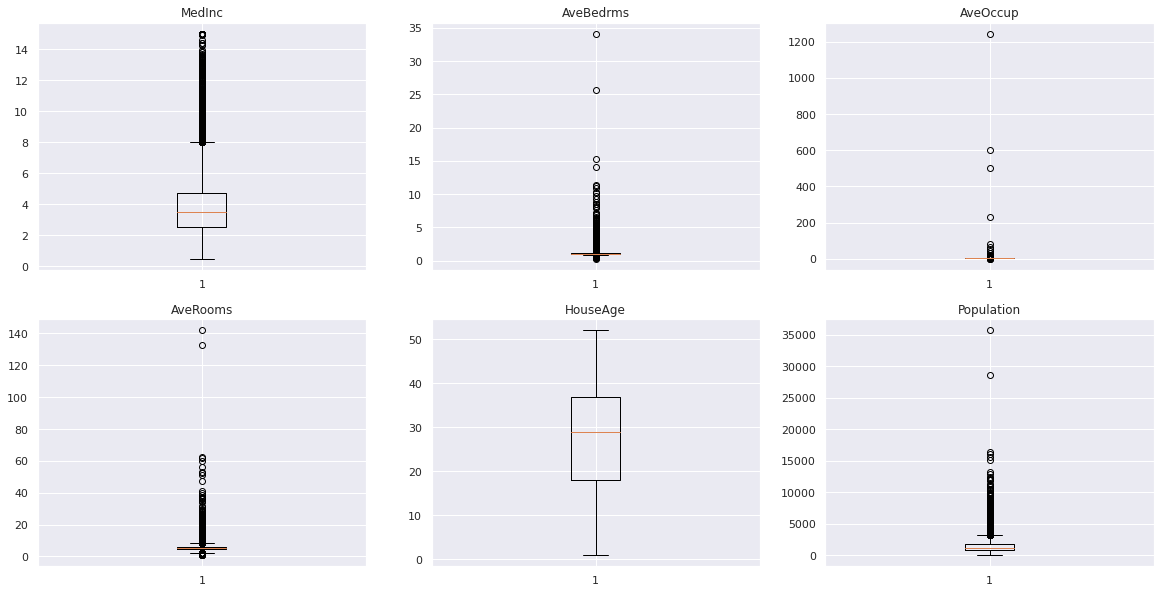

In [16]:
fig, ax = plt.subplots(2, 3)
ax[0,0].boxplot(X.MedInc)
ax[0,0].set_title("MedInc")
ax[0,1].boxplot(X.AveBedrms)
ax[0,1].set_title("AveBedrms")
ax[0,2].boxplot(X.AveOccup)
ax[0,2].set_title("AveOccup")
ax[1,0].boxplot(X.AveRooms)
ax[1,0].set_title("AveRooms")
ax[1,1].boxplot(X.HouseAge)
ax[1,1].set_title("HouseAge")
ax[1,2].boxplot(X.Population)
ax[1,2].set_title("Population")

## Feature Engineering

In [17]:
q1 = X.quantile(0.25)
q3 = X.quantile(0.75)
iqr = q3 - q1
iqr

MedInc          2.179850
HouseAge       19.000000
AveRooms        1.611665
AveBedrms       0.093447
Population    938.000000
AveOccup        0.852520
Latitude        3.780000
Longitude       3.790000
dtype: float64

In [18]:
X.shape

(20640, 8)

In [19]:
mask = ~((X < (q1 - 1.5 * iqr)) |(X > (q3 + 1.5 * iqr))).any(axis=1)
mask

0        False
1        False
2         True
3         True
4         True
         ...  
20635     True
20636    False
20637     True
20638     True
20639     True
Length: 20640, dtype: bool

In [20]:
mask.value_counts()

True     16842
False     3798
dtype: int64

In [21]:
X = X[mask]

(16842, 8)


In [23]:
y = y[mask]

Text(0.5, 1.0, 'Population')

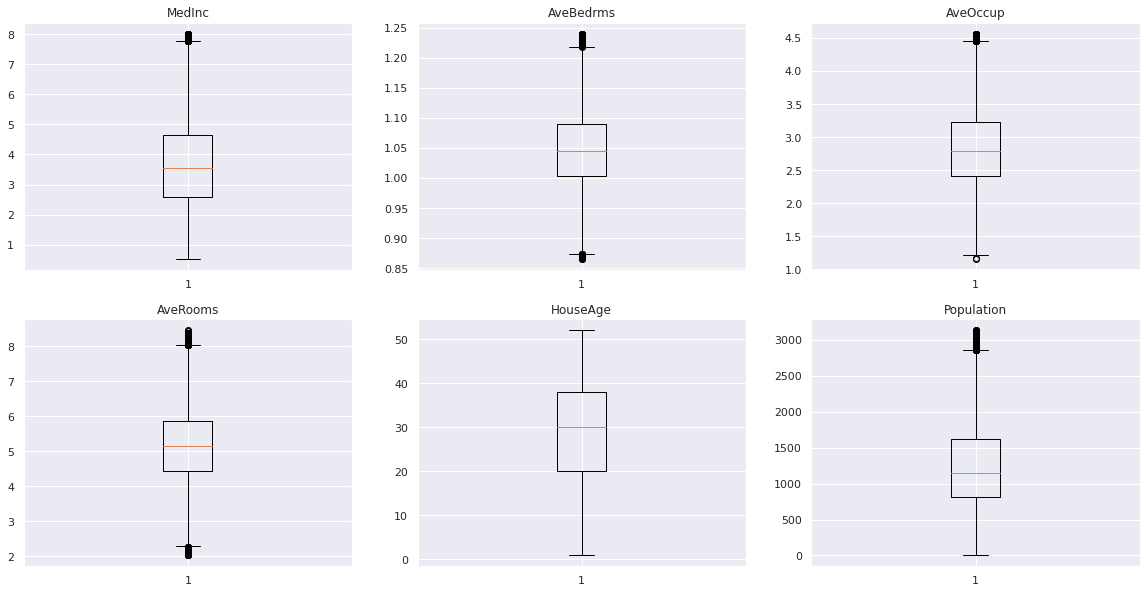

In [24]:
fig, ax = plt.subplots(2, 3)
ax[0,0].boxplot(X.MedInc)
ax[0,0].set_title("MedInc")
ax[0,1].boxplot(X.AveBedrms)
ax[0,1].set_title("AveBedrms")
ax[0,2].boxplot(X.AveOccup)
ax[0,2].set_title("AveOccup")
ax[1,0].boxplot(X.AveRooms)
ax[1,0].set_title("AveRooms")
ax[1,1].boxplot(X.HouseAge)
ax[1,1].set_title("HouseAge")
ax[1,2].boxplot(X.Population)
ax[1,2].set_title("Population")

<AxesSubplot:>

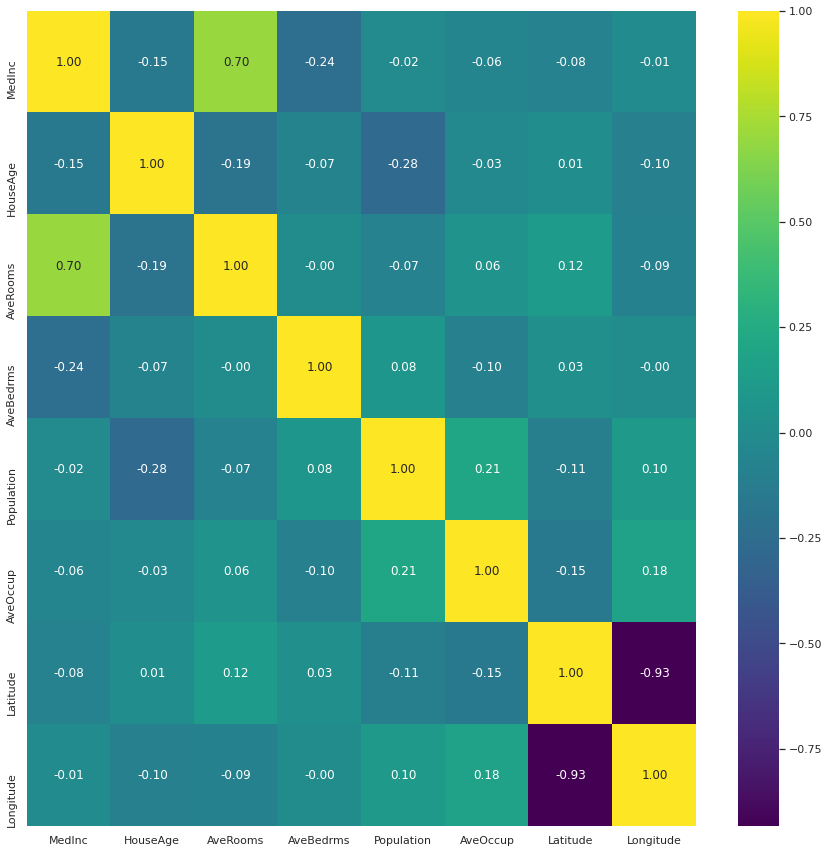

In [25]:
corr = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='viridis', annot=True, fmt='.2f')

In [26]:
poly = PolynomialFeatures(2)
X_new = poly.fit_transform(X)

labels = []
for l in X.columns:
    labels.append(l)
for i in range(X_new.shape[1]-X.shape[1]):
    labels.append('label'+str(i))
X = pd.DataFrame(X_new, columns=labels)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,label0,label1,...,label27,label28,label29,label30,label31,label32,label33,label34,label35,label36
0,1.0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,52.669855,...,246016.0,1389.920904,18773.60,-60631.04,7.852660,106.065537,-342.548249,1432.6225,-4626.7840,14942.6176
1,1.0,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,31.844578,...,311364.0,1421.753425,21120.30,-68215.50,6.492025,96.439726,-311.486301,1432.6225,-4627.1625,14945.0625
2,1.0,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,14.793254,...,319225.0,1232.528958,21385.25,-69071.25,4.758799,82.568533,-266.684363,1432.6225,-4627.1625,14945.0625
3,1.0,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,16.295754,...,170569.0,883.777202,15632.05,-50489.25,4.579156,80.995078,-261.602332,1432.6225,-4627.1625,14945.0625
4,1.0,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,13.389013,...,1196836.0,2328.474708,41396.96,-133741.50,4.530106,80.538833,-260.197471,1431.8656,-4625.9400,14945.0625


## Inference

In [27]:
transformer = StandardScaler()
X_scaled = pd.DataFrame(transformer.fit_transform(X), columns=X.columns)
X_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,label0,label1,...,label27,label28,label29,label30,label31,label32,label33,label34,label35,label36
0,0.0,2.390058,1.82111,2.960081,0.384217,-1.228198,-0.067277,1.028694,-1.308932,2.933195,...,-0.902131,-1.053193,-1.180393,1.213219,-0.169567,0.219135,-0.033126,1.017414,-1.103656,1.311844
1,0.0,1.301383,1.82111,0.614839,0.378411,-1.129112,-0.470506,1.028694,-1.313947,1.267940,...,-0.868338,-1.038560,-1.074554,1.111562,-0.531546,-0.216729,0.384264,1.017414,-1.104826,1.316957
2,0.0,0.089563,1.82111,1.055739,0.498760,-1.117925,-1.051577,1.028694,-1.313947,-0.095538,...,-0.864273,-1.125548,-1.062605,1.100092,-0.992648,-0.844828,0.986282,1.017414,-1.104826,1.316957
3,0.0,0.218103,1.82111,-0.387214,0.837013,-1.360845,-1.117489,1.028694,-1.313947,0.024607,...,-0.941148,-1.285874,-1.322080,1.349153,-1.040440,-0.916075,1.054571,1.017414,-1.104826,1.316957
4,0.0,-0.036616,1.82111,-0.225616,-1.447402,-0.272498,-1.135710,1.024004,-1.313947,-0.207825,...,-0.410432,-0.621729,-0.160057,0.233291,-1.053489,-0.936734,1.073449,1.012499,-1.101049,1.316957


In [28]:
X_train_s, X_test_s, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [35]:
lr_s = Lasso(random_state=42)
lr_s.fit(X_train_s, y_train)
yhat = lr_s.predict(X_test_s)
print_metrics(y_test, yhat)

---> MAE: 0.48200154221896235
---> MSE: 0.42267880088282106
---> RMSE: 0.6501375245921597


/home/tuts/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2849.807462405177, tolerance: 1.5503649753437814
  model = cd_fast.enet_coordinate_descent(


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = Lasso(random_state=42, )
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
print_metrics(y_test, yhat)

---> MAE: 0.48200154221896235
---> MSE: 0.42267880088282106
---> RMSE: 0.6501375245921597


/home/tuts/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2849.807462405177, tolerance: 1.5503649753437814
  model = cd_fast.enet_coordinate_descent(


In [37]:
ext = ExtraTreesRegressor()
ext.fit(X_train, y_train)
yhat = ext.predict(X_test)
print_metrics(y_test, yhat)

<ipython-input-37-515a5bf3ce62>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ext.fit(X_train, y_train)


---> MAE: 0.36272204176313455
---> MSE: 0.28834597332785705
---> RMSE: 0.5369785594675611


## Evaluation

In [ ]:
ft_ext = ext.feature_importances_
